# TUTORIAL 5: CCPL
**Author** - [Vuong NGUYEN](https://github.com/XuanMinhVuongNGUYEN)

This tutorial introduces you to the basics of the [Augmentare](https://forge.deel.ai/Fair/augmentare) library to easily use the deployment of Machine Learning techniques to augment data in **PyTorch**. This tutorial mainly explores the core features of library, the predefined losses and the models. 

This tutorial assumes that your system has installed Pytorch and Augmentare properly.

This tutorial uses the highly popular Contrastive Coherence Preserving Loss for Versatile Style Transfer or **CCPL** architecture. **Augmentare** provides a generalised implementation of **CCPL**.

**Paper** - [CCPL: Contrastive Coherence Preserving Loss for Versatile Style Transfer by Zijie Wu & al.](https://arxiv.org/pdf/2207.04808.pdf)

In [1]:
try:
    import augmentare
    print(f"Existing Augmentare {augmentare.__version__} installation found")

except ImportError:
    import subprocess
    import sys

    subprocess.check_call([sys.executable, "-m", "pip", "install", "augmentare"])
    import augmentare

    print(f"Installed Augmentare {augmentare.__version__}")

/home/vuong.nguyen/vuong/augmentare/dev_augmentare/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Existing Augmentare 0.0.1 installation found


## IMPORTS

In [2]:
# General Imports
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Pytorch and Torchvision Imports
import imageio.v3 as iio
from PIL import Image
import IPython.display as display
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
from torchvision import transforms

# Augmentare Imports
import augmentare
from augmentare.methods.style_transfer import *
from augmentare.plots.plot_losses import plot_losses

In [3]:
#Cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## DATA LOADING AND PREPROCESSING
This tutorial uses the [**Laparoscopic Image to Image Translation**](http://opencas.dkfz.de/image2image/) dataset for illustration purposes.

Here the content image is the simulated image and the style image is the real image that we want to aim for.

We then wrap the dataset in a **DataLoader**. Because in the following sections, said **DataLoader** is required to be passed as a parameter while training.

In [4]:
def train_transform():
    transform_list = [
        transforms.Resize(size=(512, 512)),
        transforms.RandomCrop(256),
        transforms.ToTensor()
    ]
    return transforms.Compose(transform_list)

In [5]:
class FlatFolderDataset(Dataset):
    def __init__(self, root, transform):
        super().__init__()
        self.root = root
        self.paths = list(Path(self.root).glob('*'))
        self.transform = transform

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(str(path)).convert('RGB')
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.paths)

    def name(self):
        return 'FlatFolderDataset'

In [6]:
def InfiniteSampler(n):
    # i = 0
    i = n - 1
    order = np.random.permutation(n)
    while True:
        yield order[i]
        i += 1
        if i >= n:
            np.random.seed()
            order = np.random.permutation(n)
            i = 0

class InfiniteSamplerWrapper(Sampler):
    def __init__(self, data_source):
        self.num_samples = len(data_source)

    def __iter__(self):
        return iter(InfiniteSampler(self.num_samples))

    def __len__(self):
        return 2 ** 31

In [7]:
content_dir = '/home/vuong.nguyen/vuong/augmentare/Datasets/SimReal/sim_resized'
style_dir = '/home/vuong.nguyen/vuong/augmentare/Datasets/SimReal/real_resized'

In [8]:
content_tf = train_transform()
style_tf = train_transform()

content_dataset = FlatFolderDataset(content_dir, content_tf)
style_dataset = FlatFolderDataset(style_dir, style_tf)

In [9]:
content_images = DataLoader(
    content_dataset, batch_size=8,
    sampler=InfiniteSamplerWrapper(content_dataset),
    num_workers=16)

style_images = DataLoader(
    style_dataset, batch_size=8,
    sampler=InfiniteSamplerWrapper(style_dataset),
    num_workers=16)

#### Show the content image

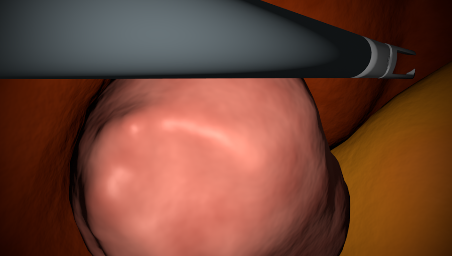

In [4]:
content_path = '/home/vuong.nguyen/vuong/augmentare/Datasets/SimReal/sim/img00003.png'
content_image = Image.open(content_path)
display.display(content_image)

#### Show the style image

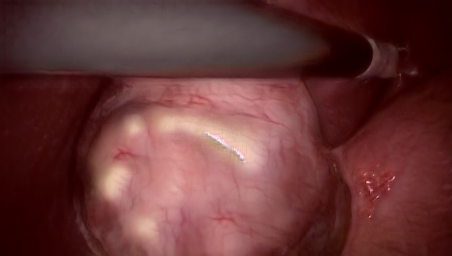

In [5]:
style_path = '/home/vuong.nguyen/vuong/augmentare/Datasets/SimReal/real/img00003.png'
style_image = Image.open(style_path)
display.display(style_image)

In [12]:
def test_transform():
    transform_list = []
    transform_list.append(transforms.Resize(512))
    transform_list.append(transforms.CenterCrop(512))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform

In [13]:
trans = test_transform()

content_image = trans(content_image)
style_image = trans(style_image)

In [14]:
content_image = np.asarray(content_image, np.float32)
style_image = np.asarray(style_image, np.float32)

In [15]:
#content_image = content_image.transpose((2, 0, 1))
#style_image = style_image.transpose((2, 0, 1))

content_image = np.expand_dims(content_image, axis=0)
style_image = np.expand_dims(style_image, axis=0)

In [16]:
content_image = torch.from_numpy(content_image)
style_image = torch.from_numpy(style_image)

## NETWORK ARCHITECTURE : CCPL

<img src="/home/vuong.nguyen/vuong/augmentare/tutorials/imgs/ccpl1.png" alt="Picture" style="display: block; margin: 0 auto" />

<span style="font-family:Roboto; color:gold"> Inspirations for CCPL: </span> <span style="font-family:Roboto"> Regions denoted by red boxes from the first frame `(RA or R'A)` have the same location with corresponding patches in the second frame wrapped in a yellow box `(RB or R'B)`. `RC and R'C` (in the blue boxes) are cropped from the first frame but their style aligns with `RB and R'B`. The difference between two patches is denoted by `D` (for example, D(RA, RB)). Mutual information between `D(RA, RC)` and `D(R'A, R'C)`, `(D(RA, RB) and D(R'A, R'B))` is encouraged to be maximized to preserve consistency from the content source. </span> </li>

<img src="/home/vuong.nguyen/vuong/augmentare/tutorials/imgs/ccpl2.png" alt="Picture" style="display: block; margin: 0 auto" />

<span style="font-family:Roboto; color:gold"> Details of CCPL: </span> <span style="font-family:Roboto"> `Cf` and `Gf` represent the encoded features of a specific layer of encoder `E`. `⊖` denotes vector subtraction, and `SCE` stands for softmax cross-entropy. The yellow dotted lines illustrate how the positive pair is produced. </span>

**CCPL**

Hyperparameters:

`training_mode:` Mode of training: Artistic or Photo-realistic

`vgg_path:` Path of vgg_normalised

`device:` CPU or CUDA

In [17]:
vgg_path = '/home/vuong.nguyen/vuong/augmentare/augmentare/methods/style_transfer/model/vgg_normalised_ccpl.pth'
model = CCPL(training_mode= "pho", vgg_path=vgg_path, device=device)

## TRAINING THE CCPL NETWORK

Train the CCPL network and return the losses.

Parameters:

`content_set:` Torch.tensor or Dataloader of content images

`style_set:` Torch.tensor or Dataloader of style images

`num_s:` Number of starting layer

`num_l:` Number of layer of CCPL

`max_iter:` Number of iteration maximun

`content_weight:` Weight of content

`style_weight:` Weight of style

`ccp_weight:` Weight of CCPL

Returns:

`loss_train:` The losses of training process CCPL

In [18]:
loss_train = model.train_network(content_images, style_images, num_s=8, num_l=3, max_iter=50000,
                        content_weight=1.0, style_weight=10.0, ccp_weight=5.0)

100%|██████████| 30000/30000 [45:09<00:00, 11.07it/s]


#### Plots the Losses

Plots losses for CCPL on a common plot.

Parameters:

`losses:` A list of losses that you want to plot

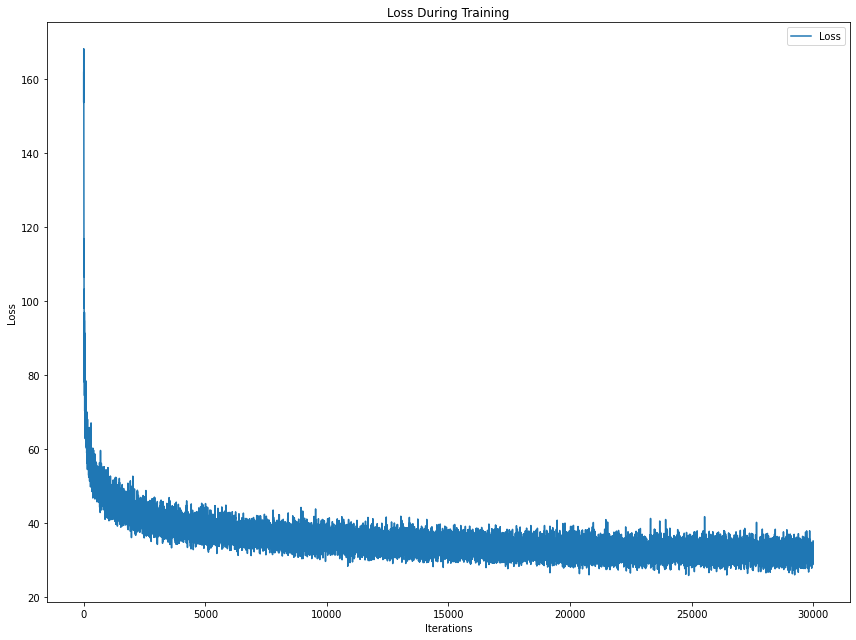

In [19]:
plot_losses(loss_train)

## VISUALIZE THE GENERATED DATA

#### Styled images from the CCPL.
A function that generates one image after training by CCPL method.

Parameters:

`content_image:` Content image that we choose to stylizer

`style_image:` Style image that we choose for style transfer

`alpha:` Alpha controls the styled degree in CCPL

`interpolation:` If true then is the case one content image, N style images

`preserve_color:` True or False

Returns:

`gen_image:` Generated image

In [20]:
gen_image = model.ccpl_generate(
    content_image, style_image,
    alpha=1.0, interpolation= False, preserve_color= True
)

In [21]:
torch.cuda.empty_cache()

In [22]:
new_im_out = np.clip(gen_image[0].permute(1, 2, 0).detach().cpu().numpy(), 0., 1.)
new_im_out = (new_im_out * 255).astype(np.uint8)

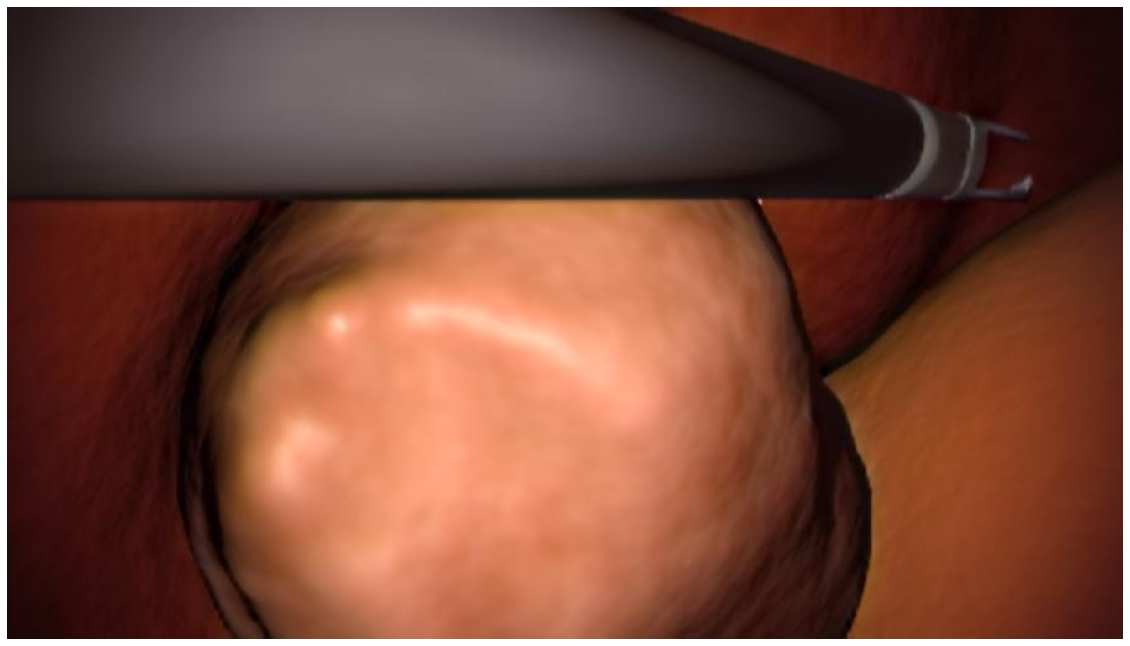

In [10]:
plt.figure(figsize=(20,25))
plt.imshow(new_im_out)
plt.axis('off')
plt.show()

In [24]:
iio.imwrite(f'/home/vuong.nguyen/vuong/augmentare/tutorials/methods/style_transfer/output/ccpl/gen_image_ccpl_3.jpg', new_im_out)

#### Plot generated image

In [9]:
output = Image.open(f'/home/vuong.nguyen/vuong/augmentare/tutorials/methods/style_transfer/output/ccpl/gen_image_ccpl_3.jpg')

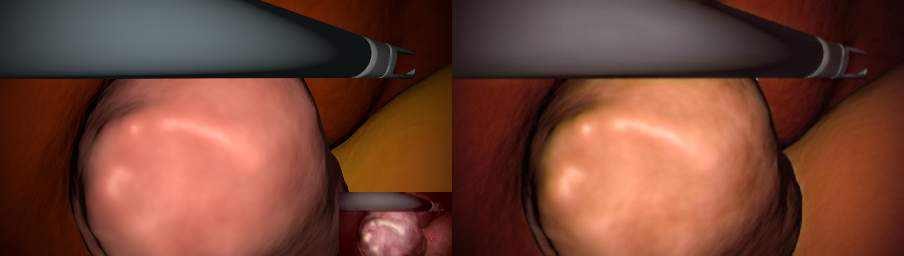

In [7]:
content_image = Image.open(content_path)
style_image = Image.open(style_path)

demo = Image.new('RGB', (content_image.width * 2, content_image.height))
output = output.resize(content_image.size)
style_image = style_image.resize((i // 4 for i in content_image.size))

demo.paste(content_image, (0, 0))
demo.paste(output, (content_image.width, 0))
demo.paste(style_image, (content_image.width - style_image.width, content_image.height - style_image.height))

display.display(demo)

In [27]:
demo.save(f'/home/vuong.nguyen/vuong/augmentare/tutorials/methods/style_transfer/output/ccpl/output3.jpg')

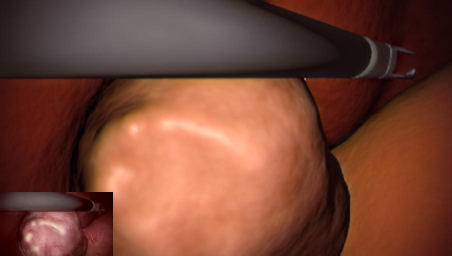

In [8]:
output.paste(style_image, (0, output.height - style_image.height))
display.display(output)